# Configuración (Constantes)

In [369]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. DATOS DE ENTRADA (PROYECTIL 1) ---
D = 100.0      # Distancia horizontal inicial (m)
h = 20.0       # Altura inicial (m)
v = 30.0       # Velocidad inicial (m/s)
phi_deg = 45.0 # Ángulo de lanzamiento (grados) - ¡AJUSTADO PARA COLISIÓN!
T = 1.0        # Tiempo de retraso del Proyectil 2 (s)

# --- 2. CONSTANTES DE SIMULACIÓN ---
g = 9.81           # Gravedad (m/s^2)
u_max = 200.0      # Velocidad máxima teórica (m/s)
C = 0.0000001      # Coeficiente de arrastre (Casi cero para esta prueba)
sigma = 0.05       # Fuerza del Ruido Blanco (Turbulencia)
dt = 0.01          # Paso de tiempo (delta t)

# Herramientas (Funciones)

In [370]:
# --- A. FUNCIÓN OBJETIVO (Física del Encuentro) ---
def F_tc(tc, D, h, v, phi_deg, T, g, u_max):
    phi_rad = np.deg2rad(phi_deg)
    
    # 1. Componente Horizontal
    denominador = tc - T
    if abs(denominador) < 1e-9: return 1e9 # Evitar división por cero
    numerador_x = D - (v * np.cos(phi_rad) * tc)
    u_x = numerador_x / denominador
    
    # 2. Componente Vertical
    term2 = v * np.sin(phi_rad) * tc
    term3 = 0.5 * g * (tc**2 - denominador**2)
    numerador_y = h + term2 - term3
    u_y = numerador_y / denominador
    
    # 3. Velocidad requerida al cuadrado vs Máxima
    return (u_x**2 + u_y**2) - u_max**2

# --- B. MÉTODO NUMÉRICO (Secante Robusta) ---
def metodo_secante(t_prev, t_i, tol):
    it = 0
    f_prev = F_tc(t_prev, D, h, v, phi_deg, T, g, u_max)
    f_i = F_tc(t_i, D, h, v, phi_deg, T, g, u_max)
    
    while True:
        it += 1
        denominador = f_i - f_prev
        if abs(denominador) < 1e-10: return t_i # Evitar error matemático
        
        t_nueva = t_i - f_i * ((t_i - t_prev) / denominador)
        
        if abs(t_nueva - t_i) < tol:
            print(f"Secante converge en {it} iteraciones. Tiempo: {t_nueva:.4f} s")
            return t_nueva
            
        t_prev, t_i = t_i, t_nueva
        f_prev, f_i = f_i, F_tc(t_i, D, h, v, phi_deg, T, g, u_max)
        if it > 50: return t_i

# --- C. FÍSICA PARA SIMULACIÓN (Derivadas y RK4) ---
def derivadas(t, estado, C_val):
    x, y, vx, vy = estado
    v_mag = np.sqrt(vx**2 + vy**2)
    ax = -C_val * v_mag * vx
    ay = -g - (C_val * v_mag * vy)
    return np.array([vx, vy, ax, ay])

def paso_rk4(t, estado, dt, C_val):
    k1 = derivadas(t, estado, C_val)
    k2 = derivadas(t + 0.5*dt, estado + 0.5*dt*k1, C_val)
    k3 = derivadas(t + 0.5*dt, estado + 0.5*dt*k2, C_val)
    k4 = derivadas(t + dt, estado + dt*k3, C_val)
    return estado + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# Ejecución Maestra (Cálculo + Simulación + Gráfica)

Secante converge en 1 iteraciones. Tiempo: 3.0000 s


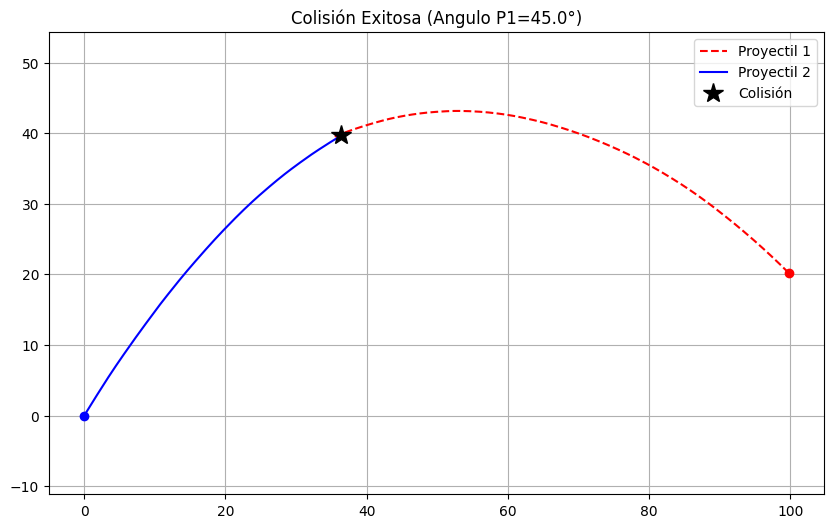

In [371]:
# 1. ENCONTRAR TIEMPO DE COLISIÓN (Usando Secante)
# Buscamos cerca de 1.5s porque cambiamos el ángulo
tc_final = metodo_secante(1.0001, 3.0, 0.0001) 

# 2. CALCULAR DATOS DE LANZAMIENTO P2 (Basado en ese tiempo)
phi_rad = np.deg2rad(phi_deg)
den = tc_final - T
ux = (D - (v * np.cos(phi_rad) * tc_final)) / den
term2 = v * np.sin(phi_rad) * tc_final
term3 = 0.5 * g * (tc_final**2 - den**2)
uy = (h + term2 - term3) / den

u_sim = np.sqrt(ux**2 + uy**2)
theta_sim = np.arctan2(uy, ux)

# 3. PREPARAR SIMULACIÓN
t = 0.0
# Estado P1
vx1 = - (v * np.cos(phi_rad)) 
vy1 = v * np.sin(phi_rad)
estado_p1 = np.array([D, h, vx1, vy1])
# Estado P2 (Inicialmente quieto, pero guardamos su velocidad de lanzamiento)
estado_p2 = np.array([0.0, 0.0, u_sim * np.cos(theta_sim), u_sim * np.sin(theta_sim)])

# Listas para guardar historia
hx1, hy1, hx2, hy2 = [], [], [], []

# 4. BUCLE DE SIMULACIÓN RK4
y1_actual, y2_actual = estado_p1[1], estado_p2[1]

# Definimos el límite temporal
t_limite = tc_final + dt 

# Cambia la condición del while:
while t < t_limite:
    # Mover P1
    estado_p1 = paso_rk4(t, estado_p1, dt, C)
    estado_p1[2] += np.random.normal(0, sigma) # Ruido
    estado_p1[3] += np.random.normal(0, sigma)
    
    # Mover P2 (Solo si es hora)
    if t >= T:
        estado_p2 = paso_rk4(t, estado_p2, dt, C)
        estado_p2[2] += np.random.normal(0, sigma)
        estado_p2[3] += np.random.normal(0, sigma)
    
    # Guardar datos
    hx1.append(estado_p1[0]); hy1.append(estado_p1[1])
    hx2.append(estado_p2[0]); hy2.append(estado_p2[1])
    
    t += dt
    y1_actual, y2_actual = estado_p1[1], estado_p2[1]
    if t > 20: break # Seguridad

# 5. GRAFICAR
plt.figure(figsize=(10, 6))
plt.plot(hx1, hy1, 'r--', label='Proyectil 1')
plt.plot(hx1[0], hy1[0], 'ro')
plt.plot(hx2, hy2, 'b-', label='Proyectil 2')
plt.plot(hx2[0], hy2[0], 'bo')
# Estrella en el punto final de P2
plt.plot(hx2[-1], hy2[-1], 'k*', markersize=15, label='Colisión')
plt.title(f'Colisión Exitosa (Angulo P1={phi_deg}°)')
plt.grid(True); plt.legend(); plt.axis('equal')
plt.show()